## Setup

In [1]:
!pip install imutils
!pip install image-classifiers==1.0.0b1

In [17]:
# import the necessary packages
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from classification_models.tfkeras import Classifiers
from datetime import datetime
%load_ext tensorboard

In [13]:
dataset_path ='./dataset'
log_path = './logs'

In [11]:
print(len(os.listdir('../input/covid-chest-xray/images/')))

NameError: name 'os' is not defined

In [14]:
%bash
rm -rf dataset
mkdir -p dataset/no-fin
mkdir -p dataset/normal
#mkdir -p dataset/pneumonia
mkdir -p logs

SyntaxError: invalid syntax (<ipython-input-14-51ae18a38a75>, line 2)

In [19]:
covid_dataset_path = r'C:\Users\Glau\Desktop\No-Findings\sample'

In [ ]:
out_dataset_path = r'C:\Users\Glau\Desktop\No-Findings\sample\no-fin'

In [23]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "sample_labels.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["Finding Labels"] != "No Finding" :
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/no-fin", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

KeyError: 'filename'

In [8]:
print(len(outputPath))

41


In [9]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [10]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:200]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [11]:
print(len(os.listdir('../working/dataset/normal')))

200


In [12]:
class_to_label_map = {'covid' : 1, 'normal' : 0}

In [13]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(class_to_label_map[label])
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [45]:
# perform one-hot encoding on the labels
# perform one-hot encoding on the labels
#labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
train_datagen = ImageDataGenerator(
                                   rotation_range=60,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                  shear_range=0.4,
                                    zoom_range=0.3,
                                 
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator()

In [46]:
trainYSparse = trainY
trainY = to_categorical(trainY)

In [47]:
from math import floor
N_FOLDS = 5
EPOCHS =100
INIT_LR = 3e-4
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=1234,)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [48]:
from tensorflow.keras import models

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras import layers
#
# image dimensions
#

img_height = 256
img_width = 256
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(32, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_549 (Conv2D)             (None, 128, 128, 32) 4736        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 128, 128, 32) 128         conv2d_549[0][0]                 
__________________________________________________________________________________________________
re_lu_33 (ReLU)                 (None, 128, 128, 32) 0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_858 (Conv2D)             (None, 16, 16, 1024) 263168      re_lu_51[0][0]                   
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 16, 16, 1024) 4096        conv2d_858[0][0]                 
__________________________________________________________________________________________________
add_24 (Add)                    (None, 16, 16, 1024) 0           leaky_re_lu_23[0][0]             
                                                                 batch_normalization_83[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_24 (LeakyReLU)      (None, 16, 16, 1024) 0           add_24[0][0]                     
__________________________________________________________________________________________________
conv2d_859

conv2d_1081 (Conv2D)            (None, 8, 8, 32)     9248        lambda_1008[0][0]                
__________________________________________________________________________________________________
conv2d_1082 (Conv2D)            (None, 8, 8, 32)     9248        lambda_1009[0][0]                
__________________________________________________________________________________________________
conv2d_1083 (Conv2D)            (None, 8, 8, 32)     9248        lambda_1010[0][0]                
__________________________________________________________________________________________________
conv2d_1084 (Conv2D)            (None, 8, 8, 32)     9248        lambda_1011[0][0]                
__________________________________________________________________________________________________
conv2d_1085 (Conv2D)            (None, 8, 8, 32)     9248        lambda_1012[0][0]                
__________________________________________________________________________________________________
conv2d_108

In [49]:
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=INIT_LR),
                  metrics=['acc', tf.keras.metrics.AUC()])

In [50]:
for epoch, skf_splits in zip(range(0,N_FOLDS),skf.split(trainX,trainYSparse)):

    train_idx = skf_splits[0]
    val_idx = skf_splits[1]
    history = model.fit(
                train_datagen.flow(trainX[train_idx], trainY[train_idx], batch_size=T_BS),
                steps_per_epoch=len(train_idx) // T_BS,
                epochs=EPOCHS,
                validation_data = val_datagen.flow(trainX[val_idx], trainY[val_idx], batch_size=V_BS),
                validation_steps = len(val_idx) // V_BS)

Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 56s 4s/step - loss: 0.6113 - acc: 0.8109 - auc_1: 0.8882 - val_loss: 1.8036 - val_acc: 0.4583 - val_auc_1: 0.4583
Epoch 2/100
13/13 [==============================] - 5s 423ms/step - loss: 0.3669 - acc: 0.8458 - auc_1: 0.9405 - val_loss: 2.4057 - val_acc: 0.4583 - val_auc_1: 0.4583
Epoch 3/100
13/13 [==============================] - 5s 410ms/step - loss: 0.2653 - acc: 0.9204 - auc_1: 0.9652 - val_loss: 2.3153 - val_acc: 0.4583 - val_auc_1: 0.4583
Epoch 4/100
13/13 [==============================] - 6s 450ms/step - loss: 0.4304 - acc: 0.8308 - auc_1: 0.9264 - val_loss: 1.8579 - val_acc: 0.4583 - val_auc_1: 0.4583
Epoch 5/100
13/13 [==============================] - 6s 433ms/step - loss: 0.3274 - acc: 0.8806 - auc_1: 0.9473 - val_loss: 5.0307 - val_acc: 0.4583 - val_auc_1: 0.4583
Epoch 6/100
13/13 [==============================] - 5s 417ms/step - loss: 0.2815 - acc: 0.9154 - auc_1: 0.9608 - va

Epoch 49/100
13/13 [==============================] - 6s 432ms/step - loss: 0.0895 - acc: 0.9602 - auc_1: 0.9954 - val_loss: 0.9038 - val_acc: 0.7292 - val_auc_1: 0.8229
Epoch 50/100
13/13 [==============================] - 6s 424ms/step - loss: 0.1630 - acc: 0.9403 - auc_1: 0.9846 - val_loss: 1.2969 - val_acc: 0.7292 - val_auc_1: 0.7791
Epoch 51/100
13/13 [==============================] - 5s 404ms/step - loss: 0.1318 - acc: 0.9602 - auc_1: 0.9902 - val_loss: 0.7958 - val_acc: 0.7500 - val_auc_1: 0.8689
Epoch 52/100
13/13 [==============================] - 5s 416ms/step - loss: 0.1409 - acc: 0.9602 - auc_1: 0.9870 - val_loss: 0.3220 - val_acc: 0.8958 - val_auc_1: 0.9553
Epoch 53/100
13/13 [==============================] - 5s 404ms/step - loss: 0.0801 - acc: 0.9602 - auc_1: 0.9960 - val_loss: 0.5998 - val_acc: 0.8958 - val_auc_1: 0.9197
Epoch 54/100
13/13 [==============================] - 6s 426ms/step - loss: 0.1516 - acc: 0.9552 - auc_1: 0.9872 - val_loss: 0.4641 - val_acc: 0.8125 

13/13 [==============================] - 5s 413ms/step - loss: 0.0516 - acc: 0.9751 - auc_1: 0.9985 - val_loss: 1.1181 - val_acc: 0.7500 - val_auc_1: 0.8134
Epoch 46/100
13/13 [==============================] - 5s 411ms/step - loss: 0.0710 - acc: 0.9652 - auc_1: 0.9972 - val_loss: 0.8787 - val_acc: 0.7917 - val_auc_1: 0.8659
Epoch 47/100
13/13 [==============================] - 6s 438ms/step - loss: 0.0519 - acc: 0.9801 - auc_1: 0.9984 - val_loss: 0.4892 - val_acc: 0.8958 - val_auc_1: 0.9423
Epoch 48/100
13/13 [==============================] - 6s 447ms/step - loss: 0.0688 - acc: 0.9751 - auc_1: 0.9976 - val_loss: 2.1151 - val_acc: 0.7083 - val_auc_1: 0.8012
Epoch 49/100
13/13 [==============================] - 6s 425ms/step - loss: 0.0741 - acc: 0.9801 - auc_1: 0.9972 - val_loss: 0.4263 - val_acc: 0.8750 - val_auc_1: 0.9375
Epoch 50/100
13/13 [==============================] - 5s 404ms/step - loss: 0.0325 - acc: 0.9900 - auc_1: 0.9997 - val_loss: 0.2654 - val_acc: 0.9167 - val_auc_1: 

13/13 [==============================] - 6s 426ms/step - loss: 0.0094 - acc: 0.9950 - auc_1: 1.0000 - val_loss: 0.1768 - val_acc: 0.9792 - val_auc_1: 0.9787
Epoch 42/100
13/13 [==============================] - 5s 406ms/step - loss: 0.0137 - acc: 0.9950 - auc_1: 0.9999 - val_loss: 0.2124 - val_acc: 0.9583 - val_auc_1: 0.9779
Epoch 43/100
13/13 [==============================] - 5s 414ms/step - loss: 0.0417 - acc: 0.9802 - auc_1: 0.9990 - val_loss: 0.0709 - val_acc: 0.9792 - val_auc_1: 0.9996
Epoch 44/100
13/13 [==============================] - 5s 404ms/step - loss: 0.0234 - acc: 0.9901 - auc_1: 0.9998 - val_loss: 0.0217 - val_acc: 0.9792 - val_auc_1: 0.9996
Epoch 45/100
13/13 [==============================] - 5s 418ms/step - loss: 0.0197 - acc: 0.9950 - auc_1: 0.9998 - val_loss: 0.0129 - val_acc: 1.0000 - val_auc_1: 1.0000
Epoch 46/100
13/13 [==============================] - 6s 457ms/step - loss: 0.0103 - acc: 0.9950 - auc_1: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000 - val_auc_1: 

13/13 [==============================] - 5s 419ms/step - loss: 0.0263 - acc: 0.9904 - auc_1: 0.9997 - val_loss: 0.1924 - val_acc: 0.9375 - val_auc_1: 0.9683
Epoch 38/100
13/13 [==============================] - 5s 417ms/step - loss: 0.0234 - acc: 0.9901 - auc_1: 0.9998 - val_loss: 0.2344 - val_acc: 0.9375 - val_auc_1: 0.9692
Epoch 39/100
13/13 [==============================] - 5s 408ms/step - loss: 0.0305 - acc: 0.9950 - auc_1: 0.9997 - val_loss: 0.3828 - val_acc: 0.8542 - val_auc_1: 0.9518
Epoch 40/100
13/13 [==============================] - 6s 425ms/step - loss: 0.0254 - acc: 0.9856 - auc_1: 0.9996 - val_loss: 0.2048 - val_acc: 0.9375 - val_auc_1: 0.9831
Epoch 41/100
13/13 [==============================] - 5s 405ms/step - loss: 0.0802 - acc: 0.9604 - auc_1: 0.9974 - val_loss: 0.7799 - val_acc: 0.9167 - val_auc_1: 0.9262
Epoch 42/100
13/13 [==============================] - 6s 426ms/step - loss: 0.1123 - acc: 0.9604 - auc_1: 0.9917 - val_loss: 0.1544 - val_acc: 0.9583 - val_auc_1: 

13/13 [==============================] - 6s 439ms/step - loss: 0.0809 - acc: 0.9802 - auc_1: 0.9937 - val_loss: 2.0536 - val_acc: 0.7917 - val_auc_1: 0.8424
Epoch 34/100
13/13 [==============================] - 5s 418ms/step - loss: 0.0177 - acc: 0.9901 - auc_1: 0.9999 - val_loss: 0.8104 - val_acc: 0.8750 - val_auc_1: 0.9175
Epoch 35/100
13/13 [==============================] - 5s 410ms/step - loss: 0.0069 - acc: 1.0000 - auc_1: 1.0000 - val_loss: 0.6104 - val_acc: 0.9167 - val_auc_1: 0.9297
Epoch 36/100
13/13 [==============================] - 6s 425ms/step - loss: 0.0129 - acc: 0.9950 - auc_1: 0.9999 - val_loss: 0.0518 - val_acc: 0.9792 - val_auc_1: 0.9987
Epoch 37/100
13/13 [==============================] - 5s 405ms/step - loss: 0.0287 - acc: 0.9901 - auc_1: 0.9996 - val_loss: 0.0349 - val_acc: 0.9583 - val_auc_1: 0.9983
Epoch 38/100
13/13 [==============================] - 5s 416ms/step - loss: 0.0209 - acc: 0.9901 - auc_1: 0.9998 - val_loss: 0.0895 - val_acc: 0.9583 - val_auc_1: 

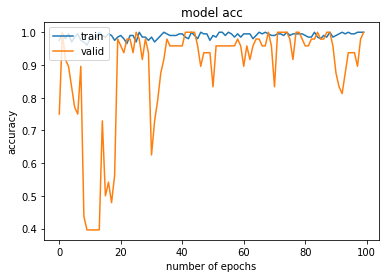

In [51]:
submission_predictions = []

preds = model.predict(testX, batch_size=V_BS)
submission_predictions.append(preds)
#print(submission_predictions)
#print(f"Test Accuracy: {submission_predictions[1]*100}")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("number of epochs")
plt.legend(["train", "valid"], loc="upper left")
plt.savefig('loss_performance'+'_'+str(epoch)+'.png')
plt.clf()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='valid')
plt.title("model acc")
plt.ylabel("accuracy")
plt.xlabel("number of epochs")
plt.legend(["train", "valid"], loc="upper left")
plt.savefig('acc_performance'+'_'+str(epoch)+'.png')    
    

In [52]:
predY = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])

In [53]:
class_to_label_map = { 1 : 'covid', 0 : 'normal'}

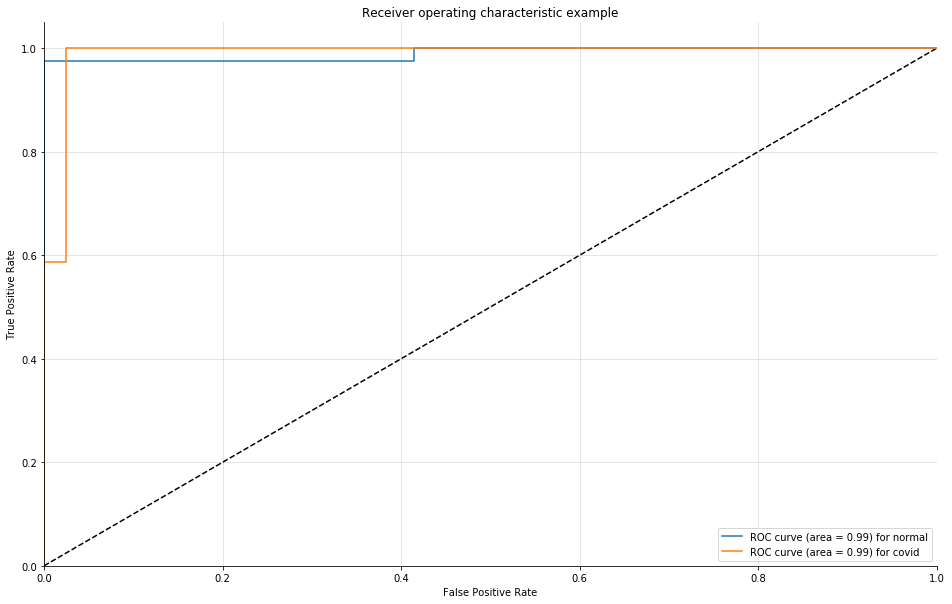

In [54]:
import seaborn as sns
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(testY, predY, n_classes=2, figsize=(16, 10))

In [55]:
cm_mat = confusion_matrix(testY, np.argmax(predY, axis = -1))

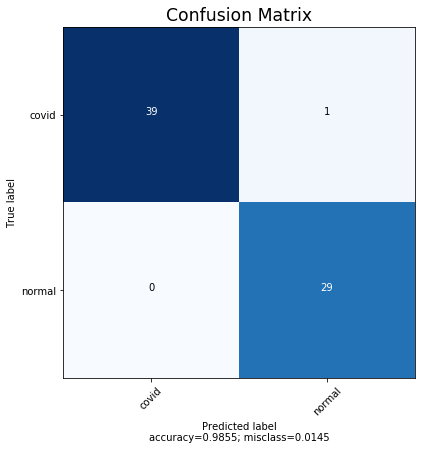

In [56]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm_mat, 
                      normalize = False,
                      target_names = ['normal', 'covid'],
                      title        = "Confusion Matrix")

In [57]:
print(classification_report(testY, np.argmax(predY, axis = -1), target_names = ['normal', 'covid']))

              precision    recall  f1-score   support

      normal       1.00      0.97      0.99        40
       covid       0.97      1.00      0.98        29

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



In [44]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY, np.argmax(predY, axis = -1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[39  1]
 [ 3 26]]
acc: 0.9420
sensitivity: 0.9750
specificity: 0.8966


In [28]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name

		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
                     
				self.model.output])

		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_JET):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

In [29]:
np.where(testY == 0)


(array([ 3,  7,  9, 11, 12, 13, 15, 17, 18, 20, 21, 23, 24, 25, 27, 28, 31,
        32, 34, 35, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54,
        55, 58, 62, 64, 65, 67]),)

In [30]:
covid1 = testX[10]
covid2 = testX[60]
covid3 = testX[8]
covid_list = [covid1, covid2, covid3]


In [31]:
image = testX[7]
preds = model.predict(image[np.newaxis,...])
preds

array([[1.0000000e+00, 4.9327795e-09]], dtype=float32)

In [32]:
image = testX[7]
preds = model.predict(image[np.newaxis,...])
preds

array([[1.0000000e+00, 4.9327795e-09]], dtype=float32)

In [1]:
#preds = model.predict(image[np.newaxis,...])
i = np.argmax(preds[0])
print(i)
# decode the ImageNet predictions to obtain the human-readable label

# # initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image[np.newaxis,...])

img_copy = np.copy(image)
img_copy -= img_copy.min((0,1))
img_copy = (255*img_copy).astype(np.uint8)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, img_copy, alpha=0.5)

NameError: name 'model' is not defined

In [2]:
print(i)

NameError: name 'i' is not defined

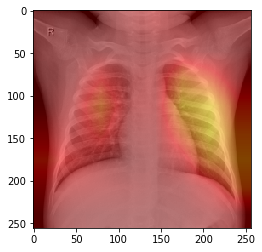

In [34]:
plt.imshow(output, cmap = 'gray')

In [35]:
def plot_map(img_list):
    fig, axes = plt.subplots(len(img_list), 2, figsize=(15, 15))
    fig.suptitle('Pneumonia Grad-CAM\n',fontsize=20)
    
    for i, img in enumerate(img_list):
        preds = model.predict(img[np.newaxis,...])
        axes[i,0].imshow(img, cmap = 'bone')
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
      #  axes[i,0].set_title(f'{class_label[np.argmax(preds[:, 1:]) + 1]} / {class_label[np.argmax(label[:, 1:]) + 1]} / {np.max(preds[:, 1:]):.4f}')
        heatmap = cam.compute_heatmap(img[np.newaxis,...])
        img_copy = np.copy(img)
        img_copy -= img_copy.min((0,1))
        img_copy = (255*img_copy).astype(np.uint8)
        # resize the resulting heatmap to the original input image dimensions
        # and then overlay heatmap on top of the image
        heatmap = cv2.resize(heatmap, (img_copy.shape[1], img_copy.shape[0]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, img_copy, alpha=0.5)
        axes[i,1].imshow(output)
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        #axes[i,1].set_title("heatmap showing hemorrhage location")
    plt.subplots_adjust(wspace=1, hspace=0.2)
    plt.savefig('CovidGradCAM.png')

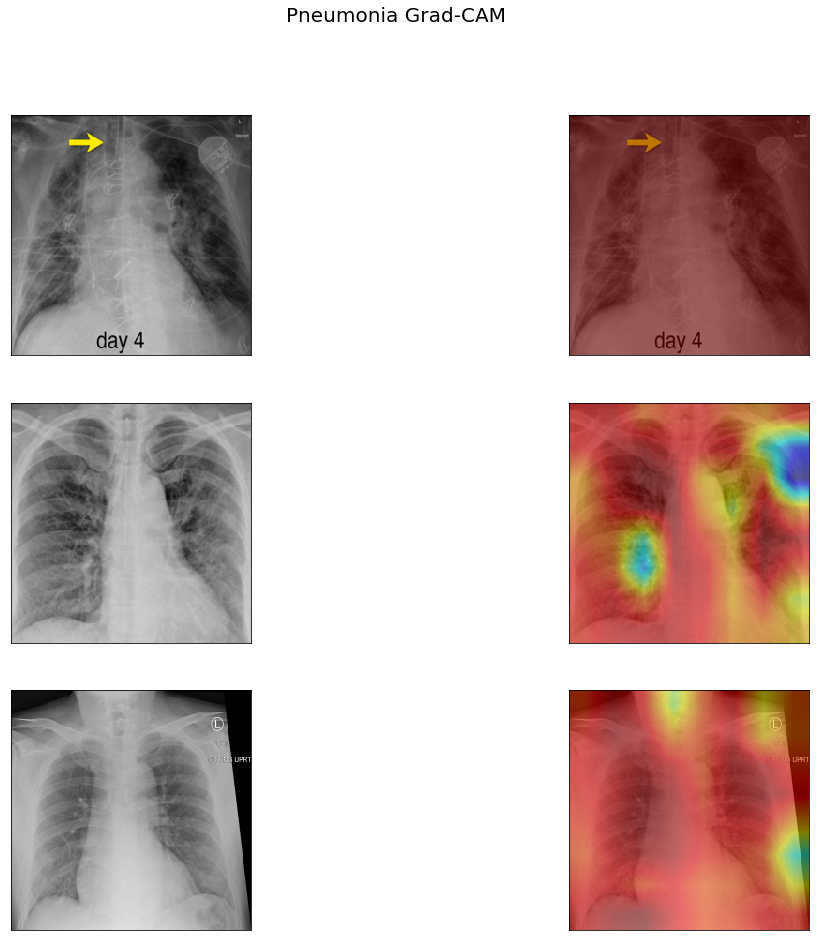

In [36]:
plot_map(covid_list)